# Regression Forest

In [1]:
import pandas

datadf = pandas.read_csv('sarcos_inv.csv')
datadf.columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22']
datadf.head()



,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,...,0.017012,-2.211089,11.989628,-7.781117,11.613101,9.550076,14.643369,1.015070,-17.048688,44.104164
1,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,...,0.015857,-2.337160,9.961797,-5.468357,9.550884,5.933340,15.467628,0.910548,-11.415526,37.354858
2,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,...,0.007958,-2.331961,7.332938,-2.434889,7.664916,3.964112,10.309203,0.921360,-5.772058,30.676065
3,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,...,-0.001271,-2.249311,3.797804,0.467865,6.160604,3.175643,2.868096,1.059957,-0.491542,25.920128
4,0.018818,-0.154544,0.034256,1.602449,0.319723,0.058259,0.036592,0.140750,-0.435916,0.318977,...,-0.006587,-2.123942,0.373019,2.622800,4.442314,2.821629,-1.571357,1.306848,4.210767,17.594261


In [2]:
import matplotlib.pyplot as plt

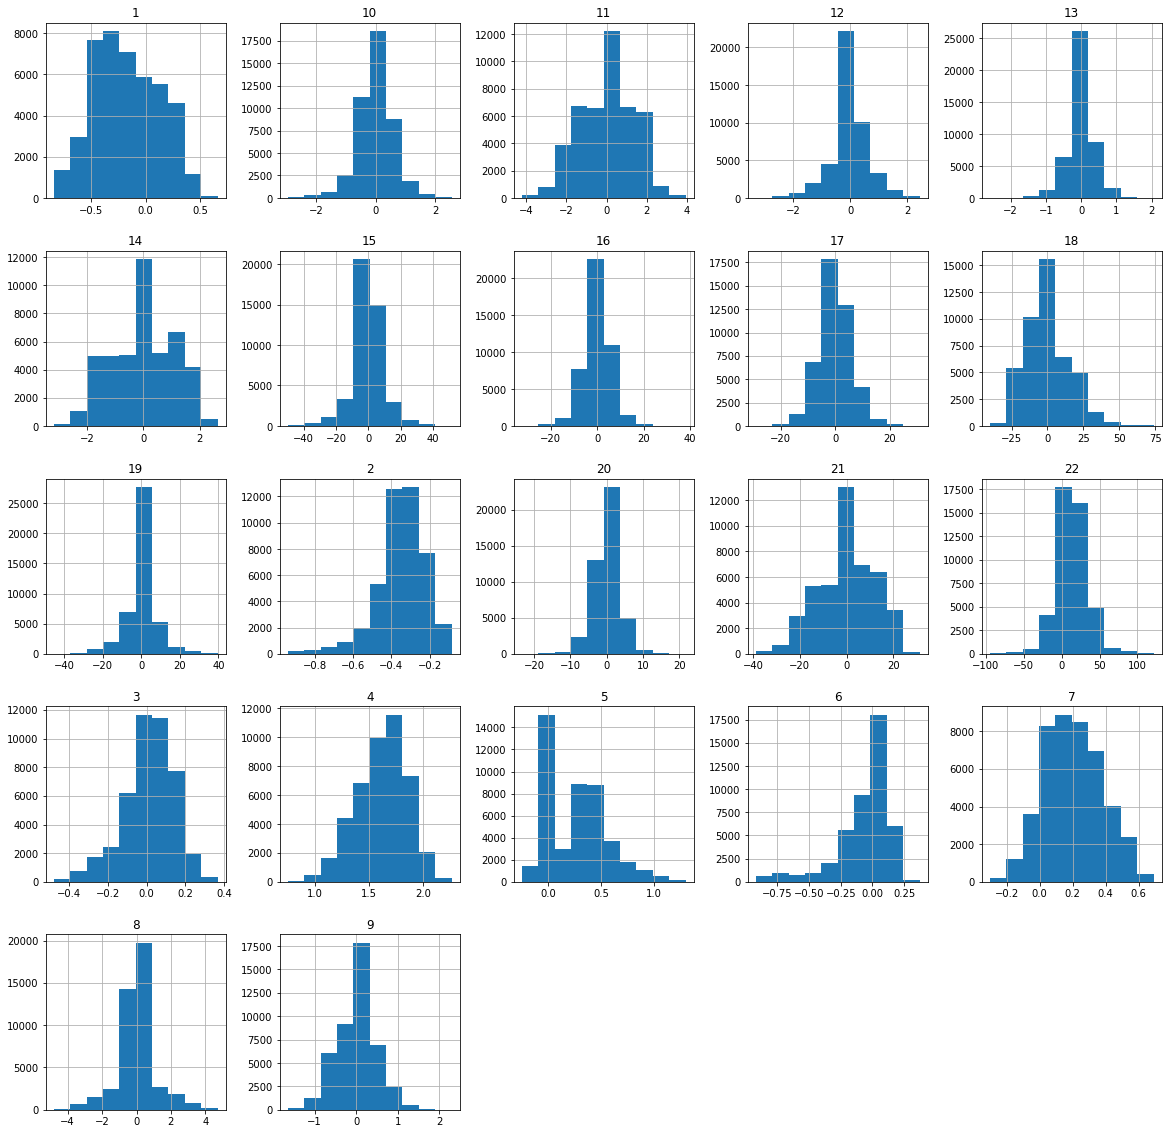

In [3]:
datadf.hist(figsize = (20, 20))
plt.show()

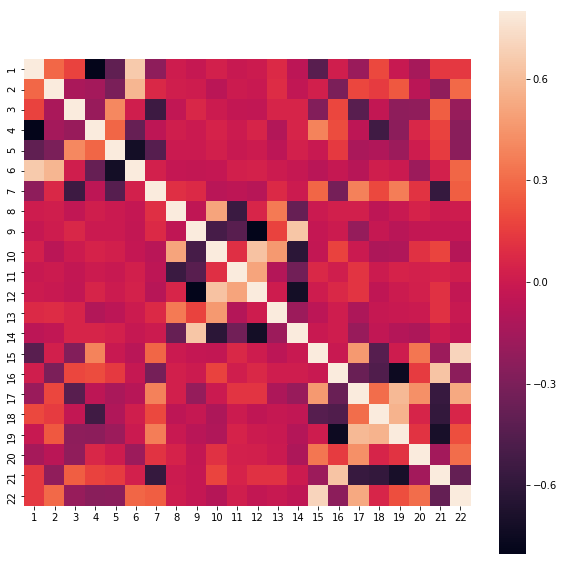

In [4]:
import seaborn as sns

corrmat = datadf.corr()
fig = plt.figure(figsize = (10, 10))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


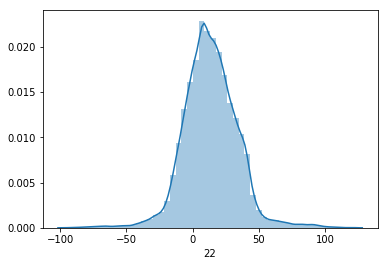

In [5]:
sns.distplot(datadf['22'])

### Regression Forest

In [6]:
import numpy as np

class CART(object):
    
    """The CART object has the following properties:
    
        tree : 'cls' or any other name. 'cls' provides criterion value as min_criterion
        criterion : 'gini' or 'mse'
        prune : 'True' or 'False' based on the condition for pruning
        max_depth : maximum depth a tree can grow
        min_criterion : minimum possible value for gain
        feature : array index numbers relating to each feature
        label : feature label provided for each predicted target
        n_samples : number of features
        gain : stores best gain value amoung all features 
        left : stores the left tree
        right : stores the right tree
        threshold : stores the best threshold value amoung all features
        depth : stores the current depth of tree
        root : stores the pivotal root of current tree
        
        """
    
    def __init__(self, tree = 'cls', criterion = 'gini', prune = 'depth', max_depth = 4, min_criterion = 0.05):
        self.feature = None
        self.label = None
        self.n_samples = None
        self.gain = None
        self.left = None
        self.right = None
        self.threshold = None
        self.depth = 0

        self.root = None
        self.criterion = criterion
        self.prune = prune
        self.max_depth = max_depth
        self.min_criterion = min_criterion
        self.tree = tree

    def fit(self, features, target):
        
        """The function fits the training features X_train 
        and target values y_train to the CART regressor.
        
        Parameters
        ----------
        self : CART object
        features : training feature dataset X_train
        target : training targets y_train
        """
        
        self.root = CART()
        if(self.tree == 'cls'):                                     # Initialises tree with default criterion
            self.root._grow_tree(features, target, self.criterion)
        else:
            self.root._grow_tree(features, target, 'mse')           # Initialises tree with MSE criterion
        self.root._prune(self.prune, self.max_depth, self.min_criterion, self.root.n_samples)

    def predict(self, features):
        
        """The function predicts the target values for
        test feature set X_test.
        
        Parameters
        ----------
        self : CART object
        features : test feature dataset X_test
        
        Returns
        -------
        y_pred = predicted values for test dataset X_test"""
        
        return np.array([self.root._predict(f) for f in features])

    def print_tree(self):
        
        """The function prints the current tree."""
        
        self.root._show_tree(0, ' ')

    def _grow_tree(self, features, target, criterion = 'gini'):
        
        """The function creates a new tree and calculates the 
        best gain, feature and threshold amoung all feature.
        
        Parameters
        ----------
        self : CART object
        features : training feature dataset
        target : training targets
        criterion: 'gini' or any other ('gini' is default)
        """
        
        self.n_samples = features.shape[0] 

        if len(np.unique(target)) == 1:
            self.label = target[0]
            return

        best_gain = 0.0
        best_feature = None
        best_threshold = None

        if criterion in {'gini', 'entropy'}:
            self.label = max([(c, len(target[target == c])) for c in np.unique(target)], key = lambda x : x[1])[0]
        else:
            self.label = np.mean(target)

        impurity_node = self._calc_impurity(criterion, target)   # Calculates impurity for target based on criterion
        
        for col in range(features.shape[1]):                     # Loops through all datapoints
            feature_level = np.unique(features[:,col])
            thresholds = (feature_level[:-1] + feature_level[1:]) / 2.0 # Divides features into two parts

            for threshold in thresholds:
                
                # Left of threshold
                target_l = target[features[:,col] <= threshold]      
                impurity_l = self._calc_impurity(criterion, target_l)   # Left impurity
                n_l = float(target_l.shape[0]) / self.n_samples

                # Right of threshold
                target_r = target[features[:,col] > threshold]
                impurity_r = self._calc_impurity(criterion, target_r)   # Right impurity
                n_r = float(target_r.shape[0]) / self.n_samples

                impurity_gain = impurity_node - (n_l * impurity_l + n_r * impurity_r)
                if impurity_gain > best_gain:                           # Best gain swapped if impurity gain calculated is larger
                    best_gain = impurity_gain
                    best_feature = col
                    best_threshold = threshold

        # Best feature, gain and threshold for current tree            
        self.feature = best_feature               
        self.gain = best_gain
        self.threshold = best_threshold
        self._split_tree(features, target, criterion)                   # Further splits tree

    def _split_tree(self, features, target, criterion):
        
        """The function splits a tree into left and right
        portions based on self.threshold value.
        
        Parameters
        ----------
        self : CART object
        features : training feature dataset
        target : training targets
        criterion: 'gini' or any other ('gini' is default)"""
        
        # Left of threshold
        features_l = features[features[:, self.feature] <= self.threshold]
        target_l = target[features[:, self.feature] <= self.threshold]
        self.left = CART()                                              # Creates new tree with left half of features
        self.left.depth = self.depth + 1
        self.left._grow_tree(features_l, target_l, criterion)
        
        # Right of threshold
        features_r = features[features[:, self.feature] > self.threshold]
        target_r = target[features[:, self.feature] > self.threshold]
        self.right = CART()                                             # Creates new tree with right half of features
        self.right.depth = self.depth + 1
        self.right._grow_tree(features_r, target_r, criterion)

    def _calc_impurity(self, criterion, target):
        
        """This function calculates impurity based on the 
        criterion provided. This is achieved by computing the 
        entropy which is the logarithmic value of the number 
        of unique features divided by number of target data.
        
        Parameters
        ----------
        self : CART object
        target : training targets
        criterion: 'gini' or any other ('gini' is default)
        
        Returns
        -------
        entropy : -p * log(p)"""
        
        if criterion == 'gini':
            return 1.0 - sum([(float(len(target[target == c])) / float(target.shape[0])) ** 2.0 for c in np.unique(target)])
        elif criterion == 'mse':
            return np.mean((target - np.mean(target)) ** 2.0)
        else:
            entropy = 0.0
            for c in np.unique(target):
                p = float(len(target[target == c])) / target.shape[0]
                if p > 0.0:
                    entropy -= p * np.log2(p)
            return entropy            

    def _prune(self, method, max_depth, min_criterion, n_samples):
        
        """This function checks whether the tree has reached its
        maximum depth. If so, it updates the pruning value to True.
        This, in turn, updates current tree's left, right branches
        and feature set to None.
        
        Parameters
        ----------
        self : CART object
        method : can be 'depth' or 'impurity'
        max_depth : maximum depth for a tree
        min_criterion : minimum possible value for gain
        n_samples : number of features
        """
        
        if self.feature is None:
            return

        self.left._prune(method, max_depth, min_criterion, n_samples)
        self.right._prune(method, max_depth, min_criterion, n_samples)

        pruning = False

        if method == 'impurity' and self.left.feature is None and self.right.feature is None: 
            if (self.gain * float(self.n_samples) / n_samples) < min_criterion:
                pruning = True
        elif method == 'depth' and self.depth >= max_depth:
            pruning = True

        if pruning is True:
            self.left = None
            self.right = None
            self.feature = None

    def _predict(self, d):
        
        """This function divides the features and grows 
        trees for left and right of threshold for prediction.
        
        Parameters
        ----------
        self : CART object
        d : feature set
        
        Returns
        -------
        left tree, right tree or label depending on condition
        """
        
        if self.feature != None:
            if d[self.feature] <= self.threshold:
                return self.left._predict(d)
            else:
                return self.right._predict(d)
        else: 
            return self.label

    def _show_tree(self, depth, cond):
        
        """This function prints feature trees in a 
        nested form
        
        Parameters
        ----------
        self : CART object
        depth : depth of current tree
        cond : condition"""
        
        base = '    ' * depth + cond
        if self.feature != None:
            print(base + 'if X[' + str(self.feature) + '] <= ' + str(self.threshold))
            self.left._show_tree(depth+1, 'then ')
            self.right._show_tree(depth+1, 'else ')
        else:
            print(base + '{value: ' + str(self.label) + ', samples: ' + str(self.n_samples) + '}')



### Implementation on SARCOS Dataset

In [7]:
import timeit
start_time = timeit.default_timer()

print('\n\nRegression Tree')
datadf_norm = (datadf - datadf.mean())/datadf.std()
datadf_norm.head()
y = datadf_norm['22'].values
x = datadf_norm[[v for v in datadf.columns if v != '22']].values
x = pandas.DataFrame(x)
X = x.values
    
split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]
    

# Fit regression model
reg = CART(tree = 'reg', criterion = 'mse', prune = 'depth', max_depth = 3)
reg.fit(X_train, y_train)
reg.print_tree()

y_pred = reg.predict(X_test)

elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')



Regression Tree
 if X[14] <= 0.907524920796845
    then if X[16] <= -0.6222599223122749
        then if X[14] <= -2.4293670984381364
            then {value: -2.6645324622046833, samples: 537}
            else {value: -0.7912728998140734, samples: 6275}
        else if X[3] <= 0.0036912636849506793
            then {value: 0.441650357988841, samples: 7833}
            else {value: -0.33930374549185555, samples: 8215}
    else if X[14] <= 2.4352819400032724
        then if X[3] <= 0.9070989095478368
            then {value: 1.3302606663478798, samples: 2318}
            else {value: 0.4632274446812545, samples: 838}
        else if X[17] <= -0.02744605059779876
            then {value: 2.3344711633833204, samples: 429}
            else {value: 3.54723192595723, samples: 244}
Runtime:  595.8045173  seconds


Mean Squared Error is:  159.66864138231495
Root Mean Squared Error is:  -0.3193002431100735


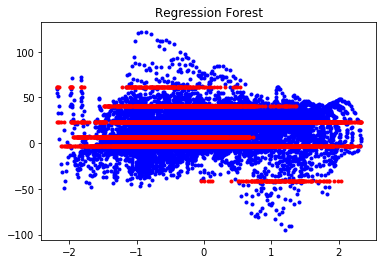

In [8]:
y_pred_unorm = (y_pred * datadf.std()[21]) + datadf.mean()[21]
y_test_unorm = (y_test * datadf.std()[21]) + datadf.mean()[21]

mse = np.mean((y_test_unorm - y_pred_unorm)**2)
print('Mean Squared Error is: ', mse)

# Root Mean Squared Error
rmse = np.mean((y_test_unorm - y_pred_unorm))
print('Root Mean Squared Error is: ', rmse)

plt.figure()
plt.plot(X_test[:,0],y_test_unorm,'b.')
plt.plot(X_test[:,0],y_pred_unorm,'r.')
plt.title('Regression Forest')
plt.show()

### Toy Problem 1: Exponential Sinusoidal Waveform

 if X[0] <= 3.211123948377245
    then if X[0] <= -0.16293974993195395
        then {value: 0.5362197407268056, samples: 76}
        else {value: 0.6437955932206525, samples: 24}
    else if X[0] <= 3.8737772384117646
        then {value: 0.10892344969130503, samples: 7}
        else {value: -0.005657866624442216, samples: 43}
Mean Squared Error is:  0.0283552089269637


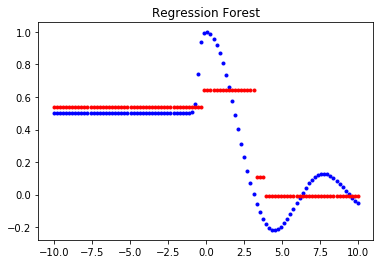

In [21]:
import math

##Example insipired from 'Learning Gaussian Process Models from Uncertain Data', Dallaire.
if __name__=="__main__":
    def sincsig(x):
        return (x>=0)*np.sinc(x/math.pi)+(x<0)*(0.5*(1 + np.exp(-10*x-5))**(-1)+0.5)
        
        
    X_train=np.random.random((150,1))*20.0-10.0
    y_train=sincsig(X_train[:,0])
    
    X_std = np.random.random(X_train.shape)*2.0+0.5
    y_std= 0.1*np.ones_like(y_train)
    y_train += np.random.normal(0.0,y_std)
    X_train += np.random.normal(0.0,X_std)
    
    X_test=np.linspace(-10,10,100).reshape(-1,1)
    y_test=sincsig(X_test[:,0])
    
    # Fit regression model
    reg = CART(tree = 'reg', criterion = 'mse', prune = 'depth', max_depth = 2)
    reg.fit(X_train, y_train)
    reg.print_tree()
    y_pred = reg.predict(X_test)
    y_pred_std = y_pred.std()

    mse = np.mean((y_test - y_pred)**2)
    print('Mean Squared Error is: ', mse)
    
    plt.figure()
    plt.plot(X_test[:,0],y_test,'b.')
    plt.plot(X_test[:,0],y_pred,'r.')
    plt.title('Regression Forest')
    plt.show()

### Toy Problem 2: Abalone Age Prediction

In [11]:
import pandas

abalonedf = pandas.read_csv('abalone.csv')

toyprob2df = abalonedf[['Length','Height','Whole weight','Rings']][:500]
toyprob2df.head()



,Length,Height,Whole weight,Rings
0,0.455,0.095,0.5140,15
1,0.350,0.090,0.2255,7
2,0.530,0.135,0.6770,9
3,0.440,0.125,0.5160,10
4,0.330,0.080,0.2050,7




Regression Tree
 if X[2] <= 0.60075
    then if X[2] <= 0.12225
        then if X[0] <= 0.14500000000000002
            then {value: 2.3333333333333335, samples: 3}
            else {value: 5.0, samples: 18}
        else if X[0] <= 0.41000000000000003
            then {value: 7.68, samples: 50}
            else {value: 9.262295081967213, samples: 61}
    else if X[2] <= 1.29925
        then if X[2] <= 0.7767499999999999
            then {value: 10.942857142857143, samples: 35}
            else {value: 12.88, samples: 100}
        else if X[1] <= 0.2025
            then {value: 15.333333333333334, samples: 21}
            else {value: 18.083333333333332, samples: 12}
Mean Squared Error is:  9.968602461815971


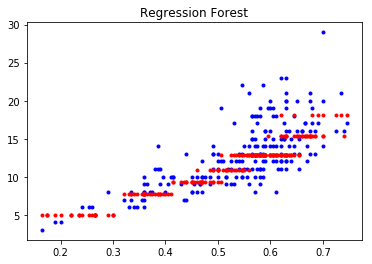

Runtime:  0.33082100000001446  seconds


In [12]:
import timeit
start_time = timeit.default_timer()

print('\n\nRegression Tree')

y = toyprob2df['Rings'].values
x = toyprob2df[[v for v in toyprob2df.columns if v != 'Rings']].values
x = pandas.DataFrame(x)
X = x.values
    
split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]
    

# Fit regression model
reg = CART(tree = 'reg', criterion = 'mse', prune = 'depth', max_depth = 3)
reg.fit(X_train, y_train)
reg.print_tree()

y_pred_tp = reg.predict(X_test)
mse = np.mean((y_test - y_pred_tp)**2)
print('Mean Squared Error is: ', mse)

plt.figure()
plt.plot(X_test[:,0],y_test,'b.')
plt.plot(X_test[:,0],y_pred_tp,'r.')
plt.title('Regression Forest')
plt.show()

elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')

### Comparison to SKLearn Model

In [13]:
import pandas

datadf = pandas.read_csv('sarcos_inv.csv')
datadf.columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22']
datadf.head()



,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,...,0.017012,-2.211089,11.989628,-7.781117,11.613101,9.550076,14.643369,1.015070,-17.048688,44.104164
1,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,...,0.015857,-2.337160,9.961797,-5.468357,9.550884,5.933340,15.467628,0.910548,-11.415526,37.354858
2,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,...,0.007958,-2.331961,7.332938,-2.434889,7.664916,3.964112,10.309203,0.921360,-5.772058,30.676065
3,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,...,-0.001271,-2.249311,3.797804,0.467865,6.160604,3.175643,2.868096,1.059957,-0.491542,25.920128
4,0.018818,-0.154544,0.034256,1.602449,0.319723,0.058259,0.036592,0.140750,-0.435916,0.318977,...,-0.006587,-2.123942,0.373019,2.622800,4.442314,2.821629,-1.571357,1.306848,4.210767,17.594261


In [14]:
import timeit
start_time = timeit.default_timer()


from sklearn import tree as sktree
from sklearn import preprocessing

split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]

sk_reg = sktree.DecisionTreeRegressor(max_depth = 5)
sk_reg.fit(X_train, y_train)
sk_pred = sk_reg.predict(X_test)
mse = np.mean((y_test - sk_pred)**2)
print('Mean Squared Error is: ', mse)


elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')

Mean Squared Error is:  12.143551084020766
Runtime:  0.2538089999999329  seconds
